# Class 12 - Solution Code

Predicting Evergreeness of Content using Decision Trees and Random Forests

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

### Load Dataset and Pre-Process

In [2]:
# Load data
data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')

# Split `boilerplate` column
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

# Check head
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


### Predicting "Greenness" Of Content

### Data Dictionary

This exercise uses the [Kaggle StumbleUpon Evergreen Classification Challenge](https://www.kaggle.com/c/stumbleupon)

This dataset comes from [StumbleUpon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [3]:
# Check URLs and their evergreen labels
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


# Part 1: Explore the dataset

### 1.1 Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [4]:
# Using groupby()
data.groupby(['is_news'])[['label']].mean()

,label
is_news,
1,0.516916
?,0.507562


In [5]:
# Using groupby()
data.groupby(['is_news'])['label'].mean()

is_news
1    0.516916
?    0.507562
Name: label, dtype: float64

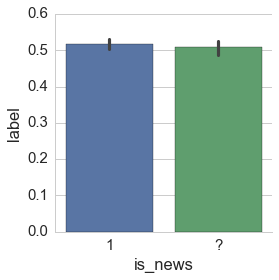

In [6]:
# Using a plot
sns.factorplot(x='is_news', y='label', kind='bar', data=data)

### 1.2 Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

In [7]:
# Using groupby()
data.groupby(['alchemy_category'])[['label']].mean()

,label
alchemy_category,
?,0.502135
arts_entertainment,0.371945
business,0.711364
computer_internet,0.246622
culture_politics,0.457726
gaming,0.368421
health,0.573123
law_crime,0.419355
recreation,0.684296


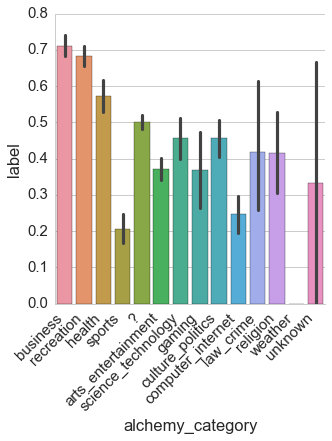

In [8]:
# Using a plot
p = sns.factorplot(x='alchemy_category', y='label', kind='bar', data=data, size = 5)
p.set_xticklabels(rotation=45, horizontalalignment='right')

### 1.3 How many articles are there per category?

In [9]:
# Using groupby()
data.groupby(['alchemy_category'])[['label']].count()

,label
alchemy_category,
?,2342
arts_entertainment,941
business,880
computer_internet,296
culture_politics,343
gaming,76
health,506
law_crime,31
recreation,1229


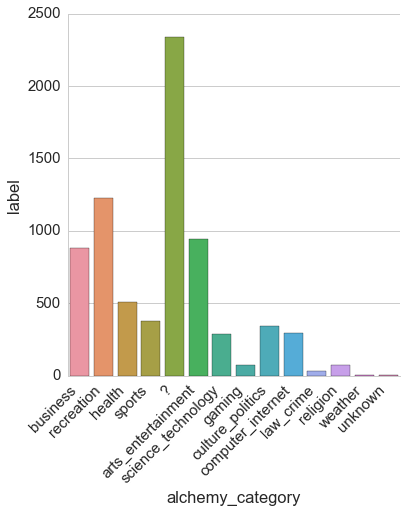

In [10]:
# Using a plot
p = sns.factorplot(x='alchemy_category', y='label', kind='bar', 
                   data=data, size=6, estimator=len)
p.set_xticklabels(rotation=45, horizontalalignment='right')

### 1.4 Explore additional relationships
Are there any other relationships you brainstormed?

### 1.5 Can you create any additional features?
Create a feature that indicates whether the title contains the word 'recipe'. Is the percent of evegreen websites higher or lower on pages that have recipe in the the title?

Hint: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html

In [11]:
# Check if title contains the word 'recipe'
data['recipe_in_title'] = data['title'].str.contains('recipe')

In [12]:
# Using groupby()
data.groupby(['recipe_in_title'])[['label']].mean()

,label
recipe_in_title,
False,0.494452
True,0.892351


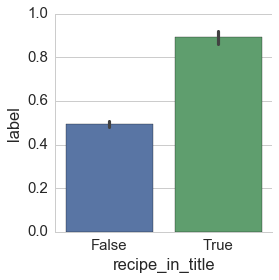

In [13]:
# Using a plot
sns.factorplot(x='recipe_in_title', y='label', kind='bar', data=data)

# Part 2:  Let's Explore Some Decision Trees

Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

### 2.1 Pre-process dataset

In [14]:
# Check dtypes and missing values
pd.DataFrame({'dtypes': data.dtypes, 'missing':data.isnull().sum()})

,dtypes,missing
url,object,0
urlid,int64,0
boilerplate,object,0
alchemy_category,object,0
alchemy_category_score,object,0
avglinksize,float64,0
commonlinkratio_1,float64,0
commonlinkratio_2,float64,0
commonlinkratio_3,float64,0
commonlinkratio_4,float64,0


In [15]:
# Drop missing values
data = data.dropna()

# Create dummy variables for alchemy_category
data = (data.join(pd.get_dummies(data['alchemy_category'], prefix='alchemy_cat'))
            .drop(['alchemy_category'], axis=1))

### 2.2 Build a Decision Tree Model

In [16]:
print data.columns
print 'alchemy_cat_unknown'.startswith('alchemy_cat_')
print filter(lambda x: x.startswith('alchemy_cat_'), data.columns)
print ['image_ratio', 'html_ratio', 'recipe_in_title']
print ['image_ratio', 'html_ratio', 'recipe_in_title'] + \
           filter(lambda x: x.startswith('alchemy_cat_'), data.columns)

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category_score',
       u'avglinksize', u'commonlinkratio_1', u'commonlinkratio_2',
       u'commonlinkratio_3', u'commonlinkratio_4', u'compression_ratio',
       u'embed_ratio', u'framebased', u'frameTagRatio', u'hasDomainLink',
       u'html_ratio', u'image_ratio', u'is_news', u'lengthyLinkDomain',
       u'linkwordscore', u'news_front_page', u'non_markup_alphanum_characters',
       u'numberOfLinks', u'numwords_in_url', u'parametrizedLinkRatio',
       u'spelling_errors_ratio', u'label', u'title', u'body',
       u'recipe_in_title', u'alchemy_cat_?', u'alchemy_cat_arts_entertainment',
       u'alchemy_cat_business', u'alchemy_cat_computer_internet',
       u'alchemy_cat_culture_politics', u'alchemy_cat_gaming',
       u'alchemy_cat_health', u'alchemy_cat_law_crime',
       u'alchemy_cat_recreation', u'alchemy_cat_religion',
       u'alchemy_cat_science_technology', u'alchemy_cat_sports',
       u'alchemy_cat_unknown', u'alchemy_cat

In [17]:
from sklearn import tree

# Set features to use
features = ['image_ratio', 'html_ratio', 'recipe_in_title'] + \
           filter(lambda x: x.startswith('alchemy_cat_'), data.columns)

# Set target variable name
target = 'label'

# Set X and y
X = data[features]
y = data[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate model using default params
tm = tree.DecisionTreeClassifier()

# Train model on training set
tm.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, tm.predict_proba(X_test)[:,1])

Accuracy: 0.565
ROC AUC: 0.565


### 2.3 Evaluate the Decision Tree Model

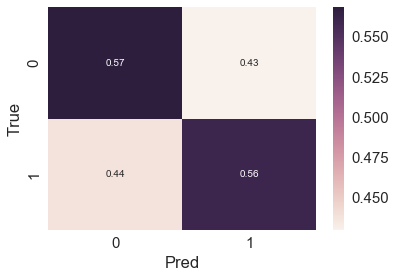

Confusion Matrix:
[[809 612]
 [662 848]]


In [18]:
# Get confusion matrix on test set
y_pred = tm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

# Part 3: Adjusting Decision Trees to Avoid Overfitting

### 3.1 Check if the model is overfit by checking accuracy on training set vs test set

In [19]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 1.000
Accuracy: 0.565


### 3.2 Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [20]:
# Instantiate model using default params
tm = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

# Train model on training set
tm.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 0.568
Accuracy: 0.560


# Part 4: Random Forests

### 4.1 Demo: Build a random forest model to predict the evergreeness of a website. 

In [22]:
from sklearn import ensemble

# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=20)

# Train model on training set
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 0.568
Accuracy: 0.560


### 4.2 Tune and update the model

Best Params:
{'n_estimators': 200}
Accuracy of current model: 0.585
Accuracy using best param: 0.601
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of current model: 0.585
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of updated model: 0.591


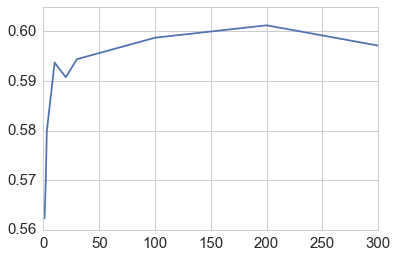

In [24]:
# Set list of values to grid search over
n = [1, 2, 3, 10, 20, 30, 100, 200, 300]
params = {'n_estimators': n}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

# Plot scores
plt.plot(n, [s[1] for s in gs.grid_scores_])



# Current model params
print rf
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)

# Update model params
rf.set_params(n_estimators=gs.best_params_['n_estimators'])

# Retrain model on new params
rf.fit(X_train, y_train)

# Updated model params
print rf
print "Accuracy of updated model: %0.3f" % rf.score(X_test, y_test)

### 4.3 Extract Feature Importances

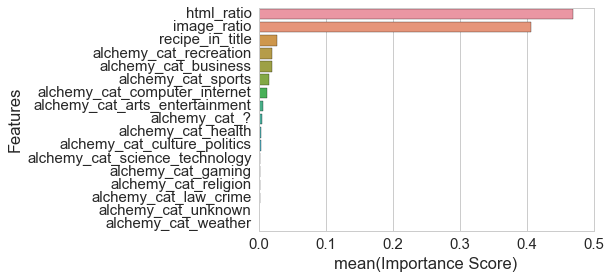

In [25]:
# Plot importances for all features
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

In [26]:
# Function to combine dummy features importances
def combine_dummies(dummy_prefixes):
    for p in dummy_prefixes:
        sub_keys = filter(lambda x: x.startswith(p), feature_dict)
        sub_keys_sum = sum([feature_dict[x] for x in sub_keys])
        for k in sub_keys: feature_dict.pop(k)
        feature_dict[p] = sub_keys_sum
    return feature_dict

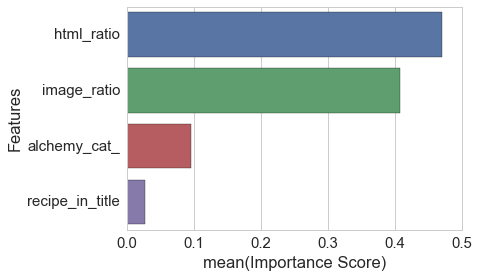

In [27]:
# Plot importances with dummy features combined
feature_names = X.columns
feature_importances = rf.feature_importances_
feature_dummy_prefixes = ['alchemy_cat_']

feature_dict = dict(zip(feature_names, feature_importances))
feature_dict = combine_dummies(feature_dummy_prefixes)

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

# Part 5: Improve Random Forest Model through Feature Engineering

### 5.1 Independent Practice: Improve model using additional (new and existing) features

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [28]:
# Create new feature to check if title contains the year
data['year_in_title'] = data['title'].str.contains('2010') | \
                        data['title'].str.contains('2011') | \
                        data['title'].str.contains('2012') | \
                        data['title'].str.contains('2013')
            
# Create new feature to check if title contains the word 'tip(s)'
data['tips_in_title'] = data['title'].str.contains('tip') | \
                        data['title'].str.contains('tips')
    
# Convert `news_front_page` to numerical
data = data.replace({'news_front_page': {'0': 0, '1': 1, '?': 2}})

Accuracy: 0.597
ROC AUC: 0.645


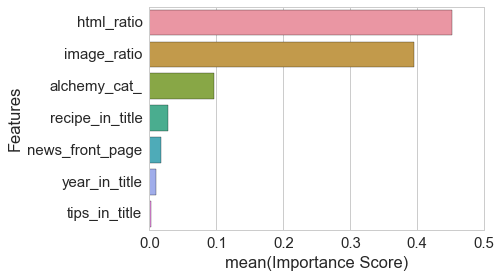

In [29]:
# Set features to use
features = ['image_ratio', 'html_ratio', 'recipe_in_title', 'year_in_title', 'tips_in_title', 'news_front_page'] + \
            filter(lambda x: x.startswith('alchemy_cat_'), data.columns)

# Set target variable name
target = 'label'

# Set X and y
X = data[features]
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)


# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
rf.fit(X_train, y_train)



# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % rf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])



# Plot importances with dummy features combined
feature_names = X.columns
feature_importances = rf.feature_importances_
feature_dummy_prefixes = ['alchemy_cat_']

feature_dict = dict(zip(feature_names, feature_importances))
feature_dict = combine_dummies(feature_dummy_prefixes)

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)